In [32]:
import sys
import numpy as np
import os
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import re
from collections import defaultdict

In [33]:
font = {'size'   : 17}

matplotlib.rc('font', **font)
pdidx = pd.IndexSlice

In [34]:
PATH = "../../../"
if PATH not in sys.path:
    sys.path.append(PATH)
from hysys_optimization.problems.dsmr.smr_opt_problem import SMROptimizationProblem

In [35]:
if not os.path.exists("./graphs"):
    os.makedirs("./graphs", exist_ok=True)

In [36]:
SIMULTAION_PATH = "Dual SMR Simulation.hsc"
smr_prob = SMROptimizationProblem(SIMULTAION_PATH, simulation_is_visible=True, do_scale=True)

## Load Data

In [37]:
RANDOM_SEEDS = [
    2, 3, 5, 7, 11, 13, 17, 19, 23, 29,
    31, 37, 41, 43, 47, 53, 59, 61, 67, 71,
    73, 79, 83, 89, 97, 101, 103, 107, 109, 113,
    127, 131, 137, 139, 149, 151, 157, 163, 167, 173,
    179, 181, 191, 193, 197, 199, 211, 223, 227, 229,
    233, 239, 241, 251, 257, 263, 269, 271, 277, 281,
    283, 293, 307, 311, 313, 317, 331, 337, 347, 349,
    353, 359, 367, 373, 379, 383, 389, 397, 401, 409,
    419, 421, 431, 433, 439, 443, 449, 457, 461, 463,
    467, 479, 487, 491, 499, 503, 509, 521, 523, 541
]

In [38]:
EXP_PATH ="FINAL"
runs = 10

algorithms = [
        'DE', 
        'GA', 
        'GBEST PSO', 
        'FERPSO', 
        'r3pso', 
        'CLDE',
        'NCDE', 
    ]

len(algorithms)

7

In [39]:
exp_dir_name = f"data/{EXP_PATH}"
ctr = 0
histories = defaultdict(lambda: defaultdict(dict))

for path in tqdm(os.listdir(exp_dir_name)):
    pattern = r"^(?P<algorithm>.*?)_rs(?P<random_state>.*?)_n(?P<n_individuals>.*?)(ns)?\.npz$"
    match = re.match(pattern, path)
    if match:
        algorithm = match.group('algorithm')
        n_individuals = int(match.group('n_individuals'))
        random_state = int(match.group('random_state'))
        do_scale = match.group(4) == None
        if random_state in RANDOM_SEEDS[:runs] and algorithm in algorithms:
            ctr += 1
            loaded = np.load(os.path.join(
                exp_dir_name, path), allow_pickle=True)
            histories[algorithm][random_state] = {k: loaded[k] for k in list(loaded.keys())}
        
print(f"Loaded {ctr} files")

  0%|          | 0/50 [00:00<?, ?it/s]

Loaded 50 files


In [40]:
df = pd.DataFrame(index=pd.Index(RANDOM_SEEDS[:runs], name="random_state"), columns=pd.MultiIndex.from_product([list(histories.keys()), ["N MF", "M MF", "E MF", "P MF", "ib MF", "ip MF",  "Suction P", "Discharge P", "MITA1", "MITA2", "Total Power"]], names=("algorithm", "attr")), dtype=float)

for algorithm in histories:
    for seed in histories[algorithm].keys():
        mask = np.logical_and(histories[algorithm][seed]["constraints"][:, 0] >= 2.95, histories[algorithm][seed]["constraints"][:, 1] >= 2.95)
        filtered_objs = histories[algorithm][seed]["objs"][mask]
        if len(filtered_objs) == 0:
            continue
        best_idx = np.argmax(filtered_objs)
        best_idx = np.arange(len(histories[algorithm][seed]["objs"]))[mask][best_idx]
        df.loc[seed, pdidx[algorithm, "Total Power"]] = - histories[algorithm][seed]["objs"][best_idx]
        if do_scale:
            df.loc[seed, pdidx[algorithm, ["N MF", "M MF", "E MF", "P MF", "ib MF", "ip MF",  "Suction P", "Discharge P"]]] = smr_prob.inverse_scale(histories[algorithm][seed]["solutions"][-1][best_idx])
        else:
            df.loc[seed, pdidx[algorithm, ["N MF", "M MF", "E MF", "P MF", "ib MF", "ip MF",  "Suction P", "Discharge P"]]] = histories[algorithm][seed]["solutions"][-1][best_idx]

        df.loc[seed, pdidx[algorithm, "Penalized Obj"]] = -histories[algorithm][seed]["penalized_objs"][-1][best_idx]
        df.loc[seed, pdidx[algorithm, ["MITA1", "MITA2"]]] = histories[algorithm][seed]["constraints"][best_idx]
df.stack("algorithm").sort_values(by="Total Power")

attr                    Discharge P      E MF      M MF     MITA1     MITA2  \
random_state algorithm                                                        
23           FERPSO       39.491705  0.843581  0.429501  3.009889  3.001846   
13           FERPSO       41.642355  0.846090  0.430545  3.032880  3.023639   
19           FERPSO       41.272773  0.829748  0.430801  3.110736  3.011807   
             r3pso        43.073239  0.829063  0.425900  3.222883  3.022140   
             GBEST PSO    35.985674  0.904451  0.432725  3.067639  3.000981   
17           CLDE         43.183159  0.838599  0.429449  3.003970  3.069259   
             GBEST PSO    48.331776  0.784906  0.430457  3.002899  3.006938   
2            NCDE         41.470826  0.848617  0.431017  3.276388  3.065302   
7            r3pso        39.425323  0.875505  0.431359  3.025793  3.001176   
3            r3pso        37.878146  0.885564  0.422986  3.824604  3.013987   
2            FERPSO       36.179461  0.922273  0.428553  3.041087  3.005849   
19           CLDE         41.882009  0.826778  0.438682  3.019513  3.001975   
13           GBEST PSO    39.990245  0.876301  0.423115  3.019740  3.013788   
17           r3pso        41.608665  0.823844  0.420713  3.434592  3.029341   
13           r3pso        42.957086  0.829250  0.424771  3.320039  3.074768   
5            FERPSO       35.000000  0.937033  0.430087  3.096709  3.012448   
7            FERPSO       50.240894  0.765288  0.428274  3.066596  3.018693   
2            GBEST PSO    37.987252  0.945322  0.429748  3.006320  3.001021   
11           CLDE         43.913405  0.823635  0.438161  3.144310  3.062774   
23           CLDE         46.108653  0.816383  0.437152  3.042956  3.016591   
3            FERPSO       37.629462  0.924609  0.436007  3.028029  3.009250   
             GBEST PSO    35.000000  0.950395  0.429428  3.107291  3.001373   
2            CLDE         39.984675  0.906733  0.424911  3.157986  3.122274   
29           GBEST PSO    36.765075  0.910914  0.433619  3.018925  2.999939   
3            CLDE         41.561315  0.816355  0.433058  3.549512  3.030564   
29           CLDE         35.000000  0.923555  0.435184  3.003982  3.008454   
13           CLDE         38.322396  0.891196  0.424037  4.180589  3.117727   
29           r3pso        38.322309  0.898095  0.432914  3.146333  3.018060   
23           r3pso        53.637560  0.778630  0.425215  3.053360  3.001244   
11           GBEST PSO    35.000000  0.946884  0.434401  3.019815  3.021594   
19           NCDE         35.000000  0.856440  0.427521  4.257254  3.034521   
7            CLDE         35.000000  0.935956  0.421659  3.628842  3.011827   
23           GBEST PSO    42.512680  0.907227  0.432125  3.109337  3.033833   
5            NCDE         43.212572  0.804761  0.426193  3.035978  3.204795   
11           r3pso        39.384387  0.920077  0.435656  3.003790  3.021169   
7            GBEST PSO    35.000000  0.967001  0.434663  3.002381  3.001339   
29           NCDE         37.714318  0.895539  0.443219  3.087781  3.061971   
5            r3pso        36.173495  0.979585  0.422649  3.270854  3.002075   
2            r3pso        35.000000  0.996853  0.423276  3.010296  3.003663   
17           FERPSO       46.826118  0.850338  0.433102  3.073558  2.999438   
23           NCDE         53.021798  0.766892  0.425197  3.011247  3.035126   
29           FERPSO       35.000000  0.931328  0.437734  3.061462  3.007087   
11           FERPSO       45.785537  0.832582  0.450677  3.463307  3.009491   
7            NCDE         37.509397  0.891420  0.424313  3.000196  3.024644   
3            NCDE         42.667829  0.900948  0.433684  3.271829  3.074200   
17           NCDE         35.000000  0.888948  0.432534  4.061878  3.211194   
5            CLDE         35.000000  0.967501  0.426268  3.436458  3.049193   
11           NCDE         35.194326  0.896343  0.433010  3.218395  3.170145   
5            GBEST PSO    35.000000  0.936355  0.4

## Quality Analysis

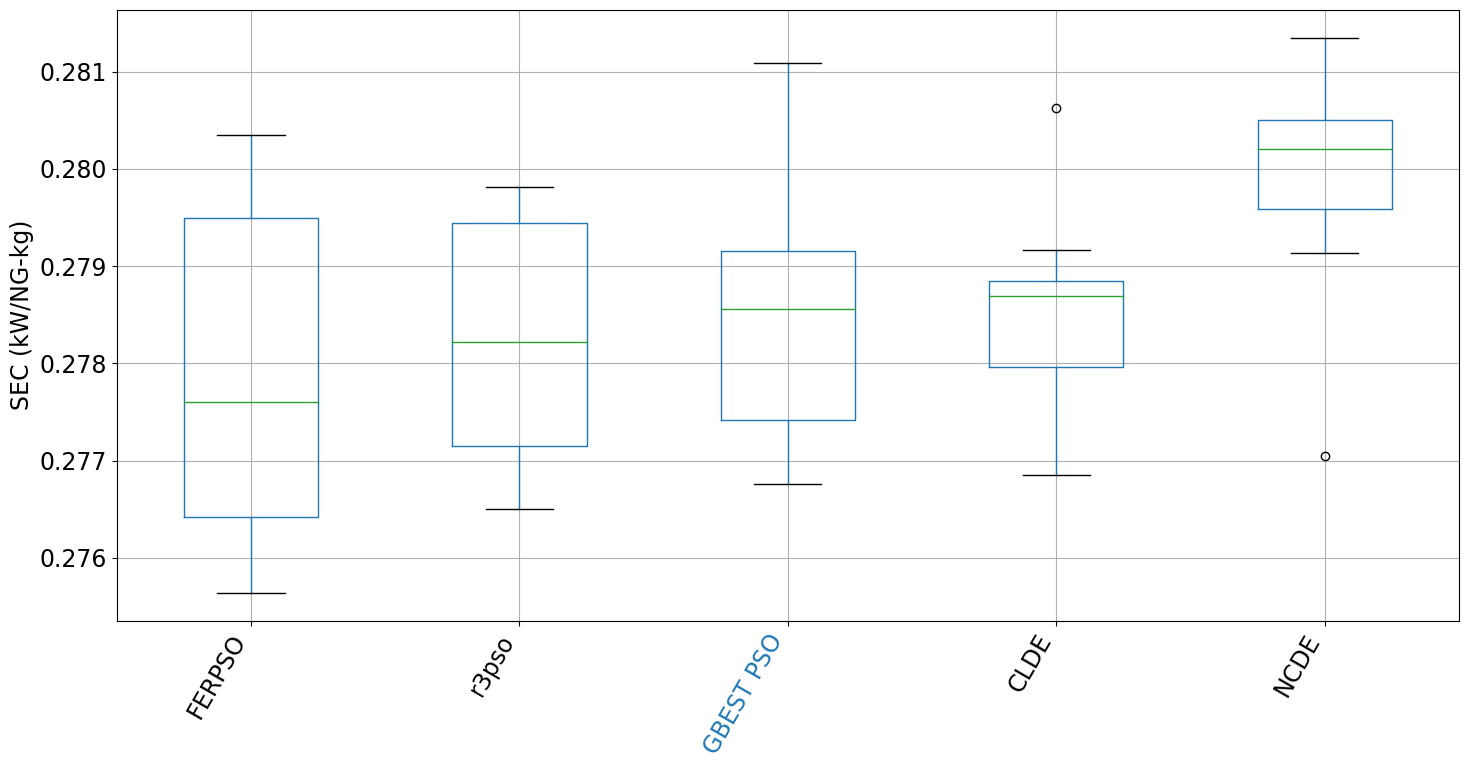

In [41]:
fig, ax = plt.subplots(figsize=(15, 8))
sorted_indices = list(df.mean(0).unstack(1).loc[pdidx[:], pdidx["Total Power"]].sort_values().index)

total_power_df = df.loc[:, pdidx[:, "Total Power", :]].droplevel(1, 1)
total_power_df.boxplot(column=list(sorted_indices), rot=60, ax=ax, ylabel="SEC (kW/NG-kg)")

ax.set_xticklabels(ax.get_xticklabels(), ha="right")

for label in ax.get_xticklabels():
    if label.get_text() in ["GBEST PSO", "DE", "GA", "SCA"]:
        label.set_color("#1f77b4")

fig.tight_layout()
fig.savefig("graphs/quality_graph.pdf")

In [42]:
tmp_df = df.stack("algorithm").round(4)
best_idx = tmp_df.groupby("algorithm")["Total Power"].idxmin()
best_solutions = tmp_df.loc[best_idx].sort_values(by="Total Power").droplevel(0, 0)[["N MF", "M MF", "E MF", "P MF", "ib MF", "ip MF",  "Suction P", "Discharge P", "MITA1", "MITA2", "Total Power", "Penalized Obj"]].sort_values(by="Total Power")

best_solutions

attr,N MF,M MF,E MF,P MF,ib MF,ip MF,Suction P,Discharge P,MITA1,MITA2,Total Power,Penalized Obj
algorithm,,,,,,,,,,,,
FERPSO,0.15,0.4295,0.8436,0.9298,0.5656,0.8637,1.9614,39.4917,3.0099,3.0018,0.2756,0.2756
r3pso,0.15,0.4259,0.8291,0.8067,0.6889,0.7715,1.9354,43.0732,3.2229,3.0221,0.2765,0.2765
CLDE,0.15,0.4294,0.8386,0.8000,0.6875,0.7970,1.9554,43.1832,3.0040,3.0693,0.2768,0.2768
GBEST PSO,0.15,0.4327,0.9045,0.8043,0.8000,0.7986,1.9498,35.9857,3.0676,3.0010,0.2768,0.2768
NCDE,0.15,0.4310,0.8486,0.8000,0.7267,0.7765,1.9518,41.4708,3.2764,3.0653,0.2770,0.2770
